# Numerical Simulation of Inflationary Dynamics

This notebook is intended to demonstrate the procedure of using our [code](https://github.com/bhattsiddharth/NumDynInflation) to compute the dynamics during inflation in the early universe. Please read our article [(arxiv:2212.00529)](https://arxiv.org/abs/2212.00529) for a detailed explaination of the code (to familiarise with the notations before proceeding).

# Background Dynamics
The first section of this notebook is dedicated to the background dynamics of inflation, which are governed by the following equations:

$$ H^2 \equiv \frac{1}{3m_p^2} \, \rho_{\phi} = \frac{1}{3m_p^2} \left[\frac{1}{2}{\dot\phi}^2 +V(\phi)\right], $$
$$ \dot{H} \equiv \frac{\ddot{a}}{a}-H^2 = -\frac{1}{2m_p^2}\, \dot{\phi}^2, $$
$$ {\ddot \phi}+ 3\, H {\dot \phi} + V_{,\phi}(\phi) = 0. $$

## Prerequisites
Before proceeding, ensure that all the required packages are installed and imported (as they are needed for the mathematical operations, and for formatting and plotting results):

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.patches as pch
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator

## Defining the model
We begin by defining the model of inflation (as considered by the reader). This involves defining the potential of the inflaton $V(\phi)$, its derivatives and any other required constants/quantities. For example, we can consider the case of the inflaton with a Starobinsky potential. 

$$ V(\phi) = V_0 \left(1 - e^{-\sqrt{\frac{2}{3}} \frac{\phi}{m_p}} \right)^2 $$

Note that we have converted all the physical quantities to its dimensionless equivalents (see [arxiv:2212.00529](https://arxiv.org/abs/2212.00529) for details). Briefly, we describe the conversions below:

$$ T = \left( t \, m_p \right) \, S~, \quad  x = \frac{\phi}{m_p}~, \quad y =  \left( \frac{\dot{\phi}}{m_p^{2}} \right) \, \frac{1}{S}~,$$
$$ z = \left( \frac{H}{ m_p} \right) \, \frac{1}{S}~, \quad A = \left( a \, m_p \right) \, S,$$

where $S$ is a factor used to re-scale the time-variable to ease the numerical computation. The factor may be suitably chosen according to the energy scale of the dynamics.

In [2]:
# This term defines one unit of time [ T = t * m_p * S ] where t is the actual cosmic time
S = 5e-5

# parameters used in the potential function
V0 = 9.450192e-11

# dimensionless potential function and its derivatives
def exp_term(x):
    return np.exp(-np.sqrt(2/3)*x)

def f(x):
    return (1-exp_term(x))**2

def dfdx(x):
    return 2*np.sqrt(2/3)*exp_term(x)*(1-exp_term(x))

def d2fdx2(x):
    return (4/3)*exp_term(x)*(2*exp_term(x)-1)

## Defining the system
In terms of these dimensionaless variables, the dynamical equations take the form:

$$ \frac{{\rm d}x}{{\rm d}T} = y ,$$
$$ \frac{{\rm d}y}{{\rm d}T} = -3 \, z \, y - \frac{v_0}{S^{2}} \,  f_{,x}(x),$$
$$ \frac{{\rm d}z}{{\rm d}T} = - \frac{1}{2} \, y^2 ,$$
$$ \frac{{\rm d}A}{{\rm d}T} = A \, z .$$

To solve this system as an initial value problem, we provide initial conditions to our dimensionless quantities. It should be noted that the dynamics are, in general, highly sensitive to initial conditions (please refer to [arxiv:2212.00529](https://arxiv.org/abs/2212.00529) for details).

In [3]:
xi = 5.750152
yi = 0
zi = np.sqrt(yi**2/6 + (V0*f(xi)/(3*S**2)))
Ai = 1e-3

We then define our system of equations and solve them using the *odeint* function from the [SciPy](https://docs.scipy.org/doc/scipy/) library.

In [4]:
def sys(var, T):
    [x, y, z, A] = var
    dxdT = y
    dydT = -3*z*y - V0*dfdx(x)/S**2
    dzdT = -0.5*y**2
    dAdT = A*z
    return [dxdT, dydT, dzdT, dAdT]

# the period of time over which the system is integrated
T = np.linspace(0, 1000, 100000)

sol = odeint(sys, [xi,yi,zi,Ai], T, rtol=3e-14, atol=2e-35, mxstep=900000000)
x, y, z, A = np.transpose(sol)
phi, phi_t, H = x, y*S, z*S #converting back to dimensional quantities

## Defining useful parameters
Finally, after solving the system of equations, we can define derived quantities which are important to the system being considered. These are:

- The number of e-folds before the end of inflation: $N_e  = \log_e{\dfrac{a_{\rm end}}{a(t)}}=\int_{t}^{t_{\rm end}} H(t') dt'$
- The slow-roll parameters: $\epsilon_H = -\dfrac{\dot{H}}{H^2}=\dfrac{1}{2m_p^2}\dfrac{\dot{\phi}^2}{H^2}~,~~\eta_H = -\dfrac{\ddot{\phi}}{H\dot{\phi}}=\epsilon_H  - \dfrac{1}{2\epsilon_H} \, \dfrac{d\epsilon_H}{dN_e}$
- The power spectra of scalar and tensor fluctuations: $P_{\zeta} = \dfrac{1}{8\pi^2}\left(\dfrac{H}{m_p}\right)^2\dfrac{1}{\epsilon_H}~,~~P_T(k)  = \dfrac{2}{\pi^2} \left( \dfrac{H}{m_p} \right)^2$
- The scalar spectral tilt: $n_s = 1 + 2\eta_H - 4\epsilon_H~$ and the tensor-to-scalar ratio: $r = 16\epsilon_H$

We write these in terms of our dimensionless quantities as (in code):

In [5]:
N = np.log(A/Ai) # number of e-folds of expansion elapsed
Nt = 77.4859 # number of e-folds elapsed when inflation ends
Ne = Nt - N

epsH = -(-z**2 + ((V0*f(x)/S**2 - y**2))/3)/z**2 # indicates whether the system is in a state of inflation
etaH = -(-3*z*y - V0*dfdx(x)/S**2)/(y*z) # gives the rate of change of epsH

ns = 1 + 2*etaH - 4*epsH #
r = 16*epsH
Ps = (S*z)**2 / (8 * np.pi**2 * epsH)
Pt = 2*(S*z)**2 / (np.pi**2)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9764\46122892.py:6: RuntimeWarning: divide by zero encountered in true_divide
  etaH = -(-3*z*y - V0*dfdx(x)/S**2)/(y*z) # gives the rate of change of epsH


## Plotting results
Having done the necessary calculations, we can plot the evolution of various quantities (including those mentioned earlier) and analyse their behaviour. To ensure that the output observed is valid, we constrian certain aspects of the background dynamics with observational data. They are as follows:

### 1. Check if inflation is occuring:
When the universe inflates, the number of e-folds ($N$) should increase rapidly with time; whose growth slows down substantially after the end of inflation.

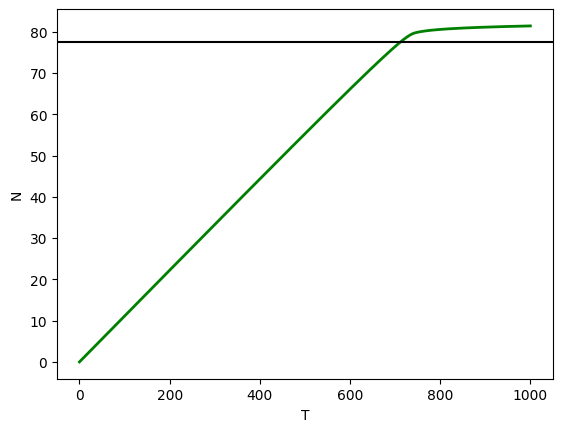

In [6]:
plt.plot(T,N,'g', lw=2)
plt.xlabel('T')
plt.ylabel('N')
plt.axhline(Nt, color='black')
plt.show()

We can observe from the plot that the universe was inflating till about T=200.

### 2. Check if inflation is adequate:

The universe experiences inflation when $\epsilon_H < 1$. As a result, the point at which its value passes 1 for the first time marks the end of inflation. The number of e-folds achieved during inflation can be obtained from here.

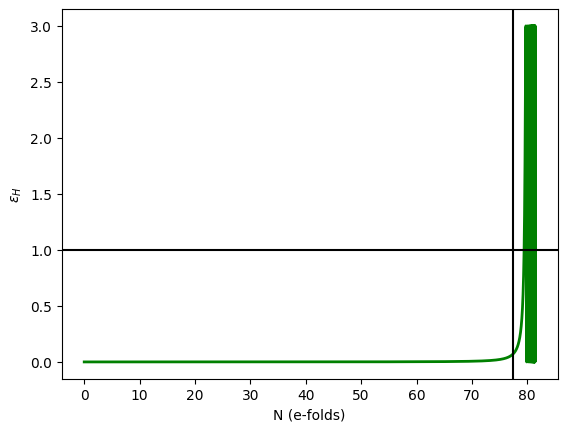

In [7]:
plt.plot(N,epsH, 'g', lw=2)
plt.axhline(1, color='black')
plt.axvline(Nt, color='black')
plt.xlabel('N (e-folds)')
plt.ylabel(r'$\epsilon_H$')
plt.show()

Here, the universe undergoes about 77 e-folds of accelerated expansion.

### 3. Matching the amplitude of power spectrum

We need to ensure that the value of the power spectrum around the CMB pivot scale, as obtained from our computation, matches with the observed value from the latest CMB data [(PLANCK 2018)](https://arxiv.org/abs/1807.06211). Adjust the value of $V_0$ in the code such that $P_s$ at $N_e=60$ should be approximately $2.1\times10^{-9}$.

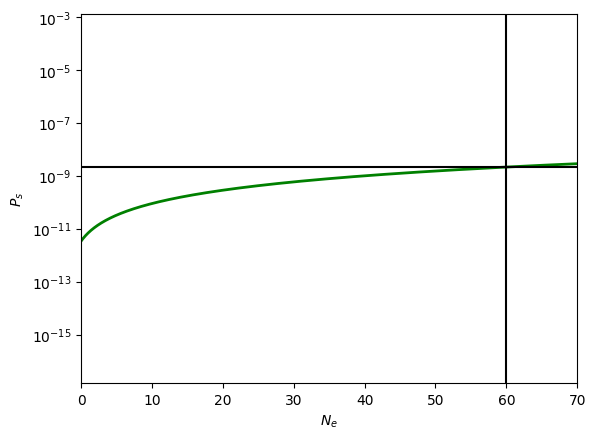

In [8]:
plt.plot(Ne,Ps, 'g', lw=2)
plt.axvline(60, color='black')
plt.axhline(2.1e-9, color='black')
plt.yscale('log')
plt.xlim(0,70)
#plt.ylim(2e-9,2.4e-9)
plt.xlabel(r'$N_e$')
plt.ylabel(r'$P_s$')
plt.show()

# First-order perturbations
As discussed elaborately in our [article](https://arxiv.org/abs/2212.00529), The  Fourier modes $v_k$ and $h_k$ (for scalar modes and tensor modes respectively) of the field satisfy the  Mukhanov-Sasaki equations which, in terms of cosmic time $t$, take the form:
$$ \ddot{v_k} +  H \dot{v_k} + \left[ \frac{k^2}{a^2} - \frac{1}{a^2} \frac{z''}{z} \right] v_k = 0 $$
$$ \ddot{h_k} +  H \dot{h_k} + \left[ \frac{k^2}{a^2} - \frac{1}{a^2} \frac{a''}{a} \right] h_k = 0 $$
As is evident from the expressions, the Fourier modes are characterised by the wavenumber $k$. In order to compute the evolution of a particular mode, we must know the time at which it becomes super-Hubble.

## Horizon exit of modes
Quantum fluctuations during inflation are generated in the sub-Hubble regime and as the Hubble radius shrinks, the comoving wavelengths of different modes become equal to the Hubble radius (i.e., $k=aH$). This is known as Hubble exit. We can determine the Hubble exit time for different modes by plotting the following:

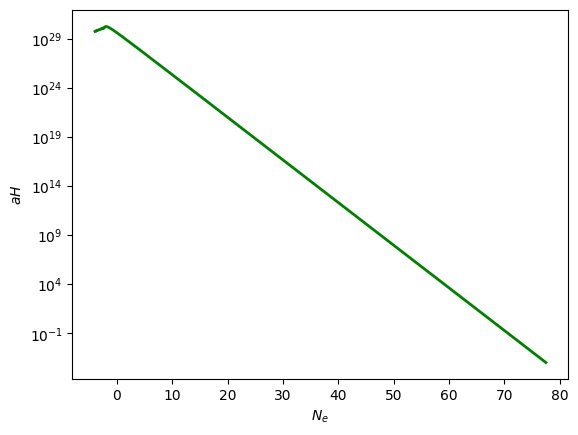

In [9]:
aH = A*z # rate of change of scale factor

plt.plot(Ne, aH, 'g', lw=2)
plt.xlabel(r'$N_e$')
plt.ylabel(r'$aH$')
plt.yscale('log')
plt.show()

For example, the mode that leaves the horizon at about 60 e-folds before the end of inflation corresponds to a wavenumber of about $10^4$. We call this the CMB pivot scale and fix its value as $0.05\,\mathrm{MPc}^{-1}$ from observations. We can then determine the wavelengths of all the modes corresponding to their horizon exit.

We can read exact values by defining an index function that returns the location of a certain value of a quantity in its evolution array and then use it to determine the wavelength of any mode by specifying its horizon exit in terms of number of e-folds before the end of inflation.

In [10]:
def i(ne):
    return np.max(np.where(Ne>=ne))

Nk = 60
k = aH[i(Nk)]
kp = aH[i(60)] #pivot scale
print(k)

4355.966487187164


## System of equations including fluctuations

We can write the Mukhanov-Sasaki equations in terms of our dimensionless variables as:
$$
v_{k,T} = \frac{{\rm d}v_k}{{\rm d}T}
$$
$$
\frac{{\rm d}v_{k,T}}{{\rm d}T} = - z \, v_{k,T} - \left[ \frac{k^2}{A^2} - \frac{5}{2} \, y^2 + 2 \, \frac{y}{z} \left(3 \, z \, y + \frac{v_0}{S^{2}} \, f_{,x} \right) - 2 \, z^2 - \frac{1}{2} \, \frac{y^4}{z^2} + \frac{v_0}{S^2} \, f_{,xx} \right]v_k
$$
$$
h_{k,T} = \frac{{\rm d}h_k}{{\rm d}T}
$$
$$
\frac{{\rm d}h_{k,T}}{{\rm d}T} = -  z \, h_{k,T} - \left(  \frac{k^2}{A^2} + \frac{1}{2} \, y^2 - 2 \, z^2  \right) \, h_k
$$

### Initial conditions
In order to simulate the evolution of a perturbation mode around its horizon exit, we enter its initial conditions when it was considerably sub-Hubble. This corresponds to the Bunch-Davies vacuum:
$$v_k = \frac{1}{\sqrt{2k}}e^{-ik\tau}$$
This is safely satisfied for every mode till about 5 e-folds before its horizon exit. Hence, we enter the values of the background quantities at this time as their initial conditions.

In [11]:
xi = x[i(Nk+5)]
yi = y[i(Nk+5)]
zi = np.sqrt(yi**2/6 + (V0*f(xi)/(3*S**2)))
Ai = 1e-3 * np.exp(Nt - (Nk+5))

# Initial conditions for the fluctuations (in Mukhanov-Sasaki variables) are given by the Bunch-Davies vacuum
vi = (1/np.sqrt(2*k)) # real part of the field that describes scalar fluctuations
ui = 0 # imaginary part of the field that describes scalar fluctuations
v_Ti = 0
u_Ti = -k*(1/np.sqrt(2*k))/Ai
# Same applies for tensor fluctuations too
hi = (1/np.sqrt(2*k)) # real part of the field that describes tensor fluctuations
gi = 0 # imaginary part of the field that describes tensor fluctuations
h_Ti = 0
g_Ti = -k*(1/np.sqrt(2*k))/Ai

### Redefining the system to be solved
We can now define our system of equations including the equations of motion for perturbations.

In [12]:
def sys(var, T):
    [x, y, z, A, v, v_T, u, u_T, h, h_T, g, g_T] = var

    #background
    dxdT = y
    dydT = -3*z*y - V0*dfdx(x)/S**2
    dzdT = -0.5*y**2
    dAdT = A*z

    # scalar fluctuations
    dvdT = v_T
    dv_TdT = -z*v_T + v*(2.5*y**2 + 2*y*(-3*z*y - V0*dfdx(x)/S**2 )/z + 2*z**2 + 0.5*y**4/z**2 - V0*d2fdx2(x)/S**2 - k**2/A**2)
    dudT = u_T
    du_TdT = -z*u_T + u*(2.5*y**2 + 2*y*(-3*z*y - V0*dfdx(x)/S**2 )/z + 2*z**2 + 0.5*y**4/z**2 - V0*d2fdx2(x)/S**2 - k**2/A**2)

    # tensor fluctuations
    dhdT = h_T
    dh_TdT = -z*h_T - h*(k**2/A**2 - 2*z**2 + 0.5*y**2)
    dgdT = g_T
    dg_TdT = -z*g_T - g*(k**2/A**2 - 2*z**2 + 0.5*y**2)

    return [dxdT, dydT, dzdT, dAdT, dvdT, dv_TdT, dudT, du_TdT, dhdT, dh_TdT, dgdT, dg_TdT]

## Invoking the solver
We simulate the evolution of the specified mode for just enough time such that it freezes after becoming super-Hubble. This is satisfied about 5 e-folds after horizon-exit for most modes.

In [13]:
# the period of time over which the system is integrated
T = np.linspace(0, 200, 10000)

sol = odeint(sys, [xi,yi,zi,Ai,vi,v_Ti,ui,u_Ti,hi,h_Ti,gi,g_Ti], T, rtol=3e-7, atol=2e-35, mxstep=900000000)
x, y, z, A, v, v_T, u, u_T, h, h_T, g, g_T = np.transpose(sol)

## Derived quantities
It is useful to define a quantity ($aH/k$) that indicates whether the specified mode is in the sub-Hubble or super-Hubble regime, along with all the derived quantities as defined for background calculations.

In [14]:
aH = A*z
aHk = aH/k
meff = 2.5*y**2 + 2*y*(-3*z*y - V0*dfdx(x)/S**2 )/z + 2*z**2 + 0.5*y**4/z**2 - V0*d2fdx2(x)/S**2

# slow-roll parameters
epsH = -(-z**2 + ((V0*f(x)/S**2 - y**2))/3)/z**2
etaH = -(-3*z*y - V0*dfdx(x)/S**2)/(y*z)

# observable quantities (under slow-roll apparoximation)
N = np.log(A/Ai) 
Ne = Nt - N
ns = 1 + 2*etaH - 4*epsH
r = 16*epsH
Ps = (S*z)**2 / (8 * np.pi**2 * epsH)
Pt = 2*(S*z)**2 / (np.pi**2)

# values of power spectra
zeta2 = (v**2 + u**2)/(2*epsH*(A/S)**2) # scalar fluctuations
P_S = (k**3 * zeta2)/(2*np.pi**2)
h2 = 4*(h**2 + g**2)/((A/S)**2) # tensor fluctuations
P_T = (k**3 * h2)/(np.pi**2)

## Plotting
We can plot the evolution of the specified mode around its horizon exit as:

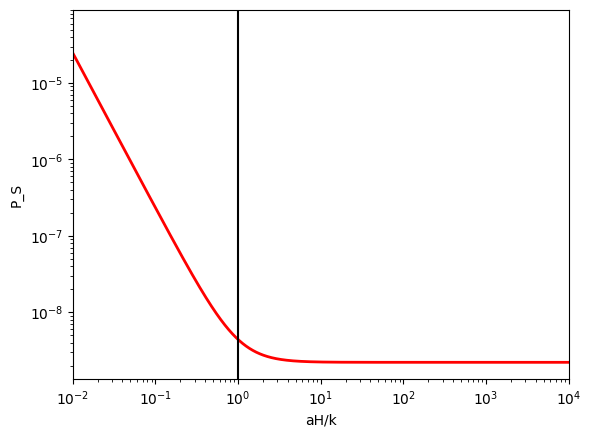

In [15]:
plt.plot(aHk,P_S,'r', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('aH/k')
plt.ylabel('P_S')
plt.xlim(1e-2, 1e4)
plt.axvline(1, color='black')
plt.show()

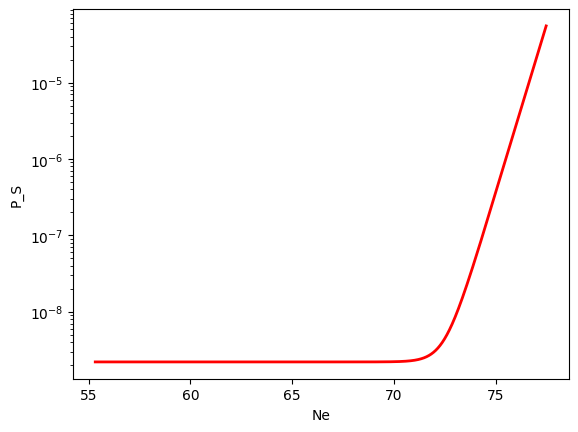

In [16]:
plt.plot(Ne, P_S,'r', lw=2)
plt.yscale('log')
plt.xlabel('Ne')
plt.ylabel('P_S')
plt.show()